In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
stock_data = pd.read_csv(r'/content/drive/MyDrive/NFLX.csv', index_col = 'Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000


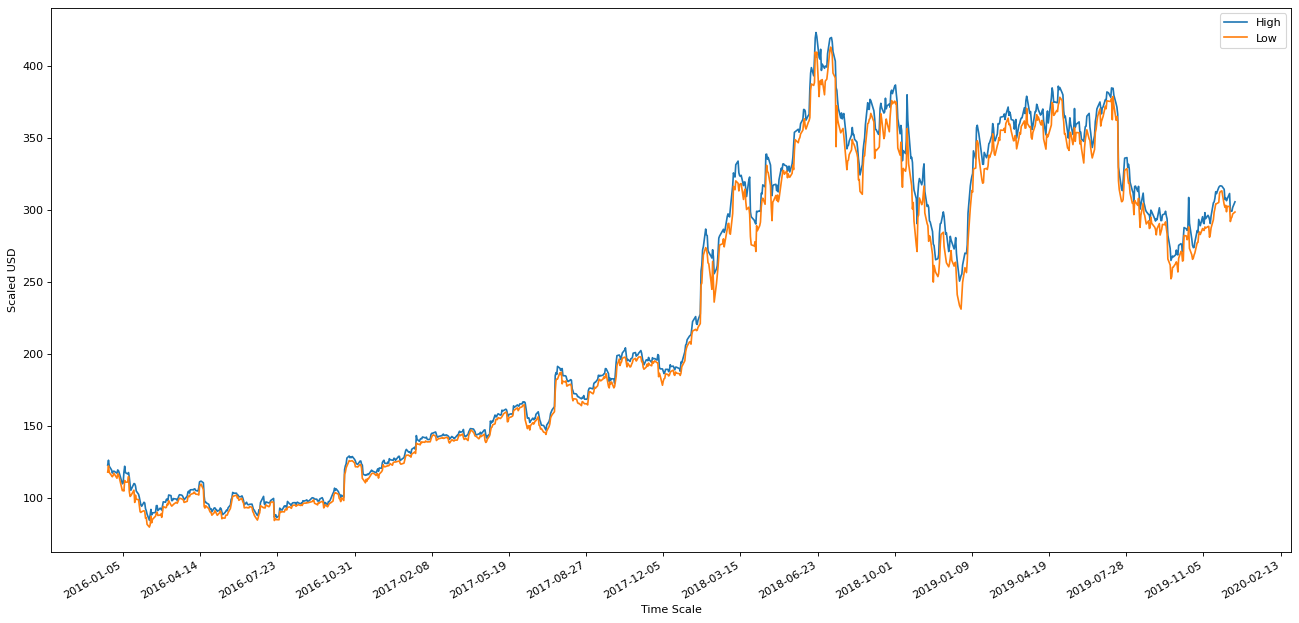

In [13]:
import matplotlib.dates as mdates
import datetime as dt

# Define the figure size and resolution
fig, ax = plt.subplots(figsize=(20, 10), dpi=80)

# Format the x-axis with date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=100))

# Convert the index to datetime.date objects
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index]

# Plot the high and low data
ax.plot(x_dates, stock_data['High'], label='High')
ax.plot(x_dates, stock_data['Low'], label='Low')

# Add labels and legend
ax.set_xlabel('Time Scale')
ax.set_ylabel('Scaled USD')
ax.legend()

# Auto-format the x-axis date labels
fig.autofmt_xdate()

# Show the plot
plt.show()


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [15]:
# Set the target variable to be the 'Close' column
target_y = stock_data['Close']
# Set the feature variables to be the first three columns of the DataFrame
X_feat = stock_data.iloc[:,0:3]

In [16]:
#Feature Scaling
sc = StandardScaler() # Create a StandardScaler object

# Scale the feature variables using the StandardScaler object
X_ft = sc.fit_transform(X_feat.values)

# Create a new DataFrame with the scaled values and the original column names and indices
X_ft = pd.DataFrame(columns= X_feat.columns, data=X_ft, index=X_feat.index)

In [17]:
def lstm_split(data, n_steps):
    # Initialize empty lists for input and output sequences
    input_seqs, output_seqs = [], []

    # Create sequences of length n_steps from the input data
    for i in range(len(data) - n_steps + 1):
        input_seq = data[i:i + n_steps, :-1]
        output_seq = data[i + n_steps - 1, -1]
        input_seqs.append(input_seq)
        output_seqs.append(output_seq)

    # Convert input and output sequences to numpy arrays
    X = np.array(input_seqs)
    y = np.array(output_seqs)

    return X, y

In [18]:
# Split the data into input and output sequences
X, y = lstm_split(stock_data.values, n_steps=2)

# Define the proportion of data to be used for training
train_proportion = 0.8

# Calculate the index to split the data
split_idx = int(np.ceil(len(X) * train_proportion))

# Get the date index for the original DataFrame
date_index = stock_data.index

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

# Print the shapes of the training and testing sets
print(X.shape, X_train.shape, X_test.shape, y_test.shape)

(1006, 2, 5) (805, 2, 5) (201, 2, 5) (201,)


In [19]:
# Create a Sequential model
model = Sequential()

# Add an LSTM layer with 50 units, input shape of (n_steps, n_features), and 'relu' activation
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))

# Add another LSTM layer with 50 units and 'relu' activation
model.add(LSTM(50, activation='relu'))

# Add a Dense layer with 1 unit
model.add(Dense(1))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,451
Trainable params: 31,451
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
202/202 - 4s - loss: 149818945044480.0000 - 4s/epoch - 21ms/step
Epoch 2/100
202/202 - 1s - loss: 116633469190144.0000 - 753ms/epoch - 4ms/step
Epoch 3/100
202/202 - 1s - loss: 71605308882944.0000 - 760ms/epoch - 4ms/step
Epoch 4/100
202/202 - 1s - loss: 66293386444800.0000 - 751ms/epoch - 4ms/step
Epoch 5/100
202/202 - 1s - loss: 66120300101632.0000 - 938ms/epoch - 5ms/step
Epoch 6/100
202/202 - 1s - loss: 66244757684224.0000 - 1s/epoch - 6ms/step
Epoch 7/100
202/202 - 1s - loss: 66008580620288.0000 - 1s/epoch - 6ms/step
Epoch 8/100
202/202 - 1s - loss: 65995016241152.0000 - 1s/epoch - 6ms/step
Epoch 9/100
202/202 - 1s - loss: 65976913625088.0000 - 975ms/epoch - 5ms/step
Epoch 10/100
202/202 - 1s - loss: 65963114364928.0000 - 766ms/epoch - 4ms/step
Epoch 11/100
202/202 - 1s - loss: 65952418889728.0000 - 757ms/epoch - 4ms/step
Epoch 12/100
202/202 - 1s - loss: 65943757651968.0000 - 748ms/epoch - 4ms/step
Epoch 13/100
202/202 - 1s - loss: 65936509894656.0000 - 769ms/epoch - 

In [21]:
# Make predictions
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [22]:
# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RSME: ", rmse)
print("MAPE: ", mape)

RSME:  6825949.538446546
MAPE:  1.0808015652940142


In [23]:
# Create a Sequential model
model = Sequential()

# Add an LSTM layer with 100 units, input shape of (n_steps, n_features), and 'relu' activation
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))

# Add another LSTM layer with 100 units and 'relu' activation
model.add(LSTM(100, activation='relu'))

# Add a Dense layer with 50 units and default 'linear' activation
model.add(Dense(50))

# Add a Dense layer with 1 unit and default 'linear' activation
model.add(Dense(1))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 100)            42400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 127,901
Trainable params: 127,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Calculate the root mean squared error (RMSE) and mean absolute percentage error (MAPE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the RMSE and MAPE
print("RMSE:", rmse)
print("MAPE:", mape)

RMSE: 6825949.538446546
MAPE: 1.0808015652940142


In [25]:
# Split the data into input and output sequences
n_steps = 10
X1, y1 = lstm_split(stock_data.values, n_steps=n_steps)

# Define the train/test split ratio
train_split = 0.8

# Determine the split index
split_idx = int(np.ceil(len(X1) * train_split))

# Get the date index
date_index = stock_data.index

# Split the data into training and testing sets
X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:-n_steps]

# Print the shapes of the data arrays
print(X1.shape, X_train.shape, X_test.shape, X_test_date.shape, y_test.shape)

(998, 10, 5) (799, 10, 5) (199, 10, 5) (198,) (199,)


Test RMSE: 50.053
Test MAPE: 0.132


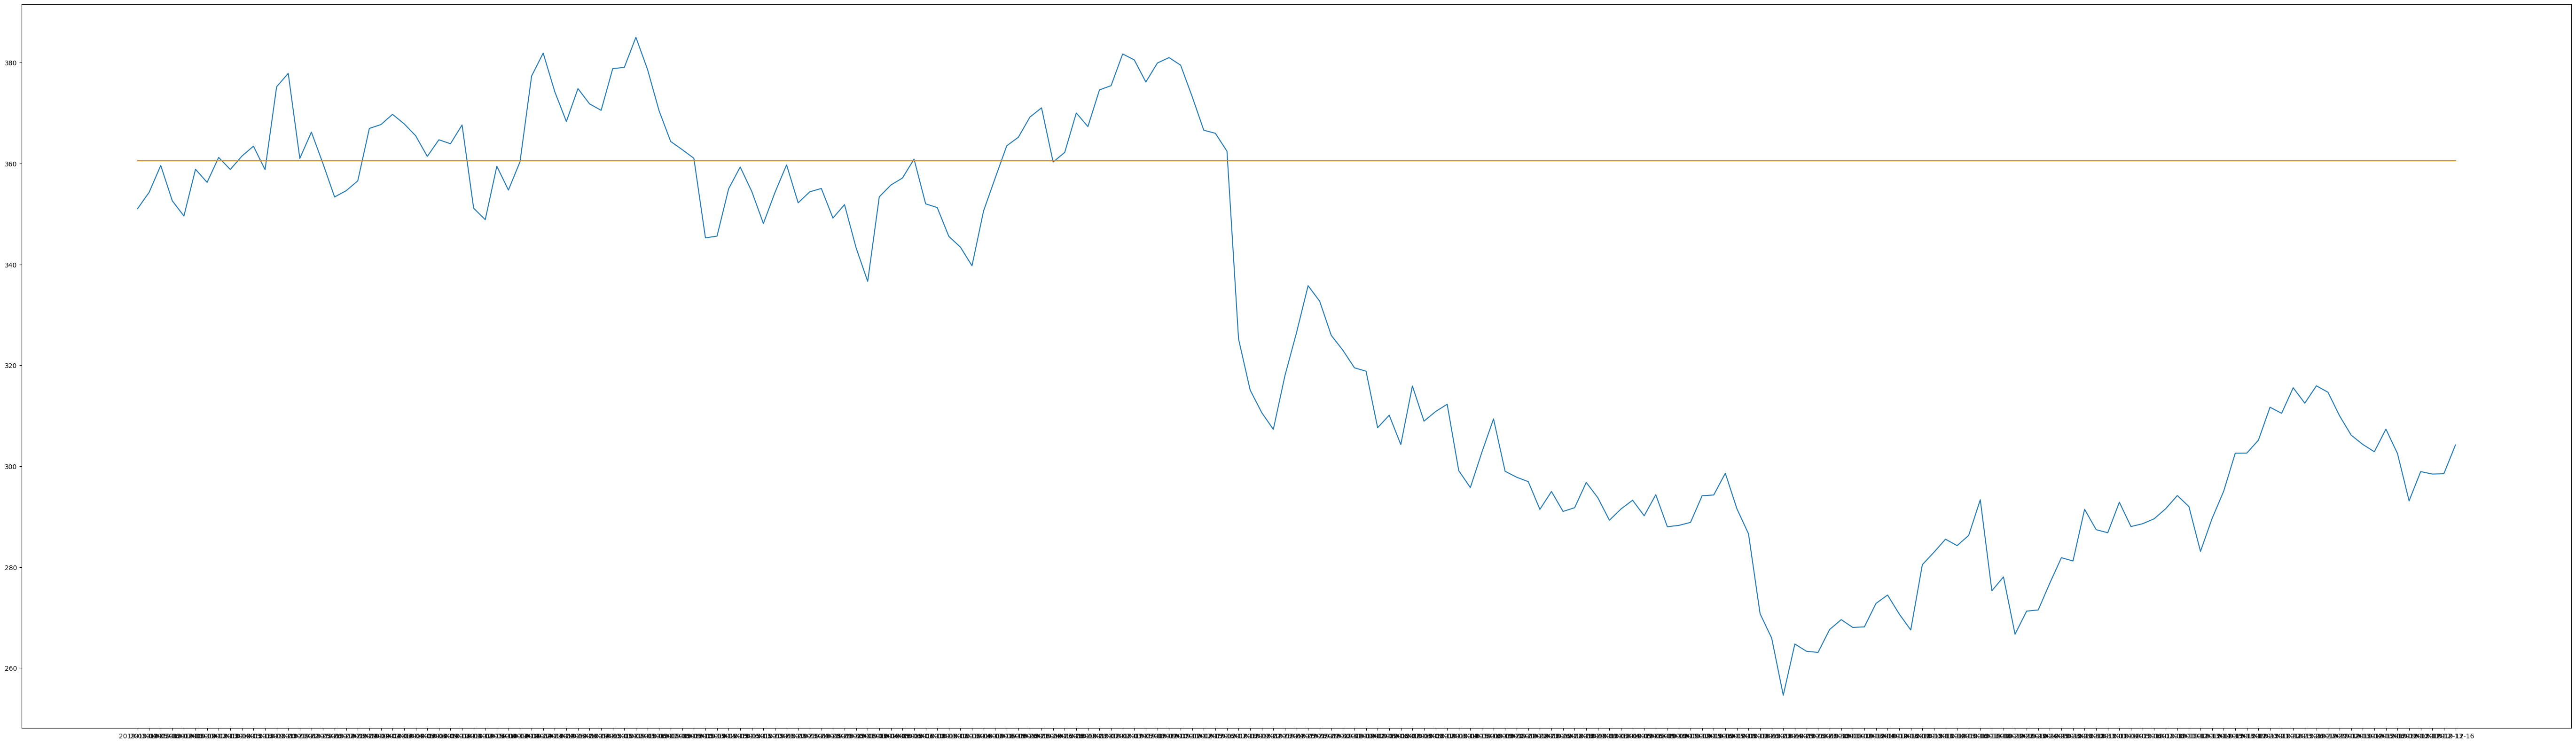

In [26]:
train_split = 0.8
split_idx = int(np.ceil(len(stock_data)*train_split))

train_data = stock_data[['Close']].iloc[:split_idx]
test_data = stock_data[['Close']].iloc[split_idx:]

test_pred = np.array([train_data.rolling(10).mean().iloc[-1]]*len(test_data)).reshape((-1,1))

rmse = mean_squared_error(test_data, test_pred, squared=False)
mape = mean_absolute_percentage_error(test_data, test_pred)

print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

# Plot the results
plt.figure(figsize= (70,20))
plt.plot(test_data)
plt.plot(test_pred)
plt.show()

In [27]:
import statsmodels.api as sm

X = stock_data[['Close']].values
train_split = 0.8
split_idx = int(np.ceil(len(X)*train_split))
train = X[:split_idx]
test = X[split_idx:]
test_pred = np.array([]).reshape((0,1))

for i in range(len(test)):
    train_fit = np.concatenate((train, np.asarray(test_pred)))
    fit = sm.tsa.SimpleExpSmoothing(np.asarray(train_fit)).fit(smoothing_level=0.2)
    test_forecast = fit.forecast(1)
    test_pred = np.concatenate((np.asarray(test_pred), test_forecast.reshape((-1,1))))

rmse = mean_squared_error(test, test_pred, squared=False)
mape = mean_absolute_percentage_error(test, test_pred)

print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 49.248
Test MAPE: 0.130
